# Algorithmic Trading Strategy Analysis: BTC/USDT Market Study
## Part I -- Implementation and Performance Analysis of Trend-Following and Mean Reversion Strategies

### Introduction

This analysis implements and evaluates two distinct algorithmic trading strategies—Moving Average Crossover (trend-following) and Bollinger Bands (mean reversion)—applied to the BTC/USDT market. The analysis covers various timeframes (1-minute, 5-minute, and 15-minute) and includes extensive parameter optimization to identify the most effective configurations for each strategy. In total ther are 16 MA strategies and 20 Bollinger Band strategies per dataset (1, 5, 15 min). This provides a broad enough sope of parameters to determine roughly in what environments thes strategies perform the best. Given running this code takes upwards of 5hrs time constraints have limited the exploraiton across an even broader set of parameters.

This part of the code will cover part 1 of the assignment. 

Initially I will outline the data collection and preparation stage.

I will move on to describe the signal generation algorithm and the optimizaton parameters including performance and risk metrics.

I will then create visualization and plot the returns, and trading signals of the strategy versus the underlying asset. The backtest will be executed feeding the data sequentially thus simulaitng a real trading environment.

Finally I will compare all the best strategies per dataset and provide more colour and possible explanations for the results we see.

### 1. Introduction and Market Context

The cryptocurrency market, particularly BTC/USDT, presents unique challenges and opportunities for algorithmic trading. Bitcoin's high volatility and 24/7 trading environment make it an ideal candidate for automated trading strategies. During the testing period (January-December 2024), the market exhibited significant volatility and directional movements, providing opportunities for both trend-following and mean reversion approaches. To be in line with the characteristics of the crypto market, trading days have been adjusted to account for 365 days of trading.

## Data gathering

Data is collected using Binance API endpoints that cover that require private API Keys to query the data. These were acquired by simply opening a Binance account and generating the necessary keys from the UI.

In the cell below we qury 1-minute candle data for the period 1 January 2024 to 1 December 2024. This period was chosen as over the year the cryptocurrency market experienced siginicant down and upswings as well as several unpredictable events that put to the test both strategies implemented at different points.

The 1- minute candle data is also resampled to generate different datasets that will be later used to measure the impact that noise can have on either strategy. The data is resmpled to 5 and 15 minute candles.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from binance.client import Client
from datetime import datetime, timedelta
import os

In [4]:
# Configure seaborn style 
sns.set_style("darkgrid")  # Use darkgrid style from seaborn
sns.set_context("notebook")  # Set context for better visibility
sns.set_palette("husl")  # Set color palette

# Initialize Binance client 
client = Client(
    os.getenv("BINANCE_API_KEY", "key"),
    os.getenv("BINANCE_API_SECRET", "secret")
)

def fetch_historical_data(symbol: str, interval: str, start_date: str, end_date: str = None) -> pd.DataFrame:
    """Fetch historical price data from Binance"""
    # Get historical klines
    klines = client.get_historical_klines(
        symbol=symbol,
        interval=interval,
        start_str=start_date,
        end_str=end_date
    )
    
    # Create DataFrame
    df = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_base',
        'taker_quote', 'ignored'
    ])
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    # Convert string columns to float
    numeric_columns = ['open', 'high', 'low', 'close', 'volume']
    df[numeric_columns] = df[numeric_columns].astype(float)
    
    return df[numeric_columns]

# Fetch data for different timeframes
symbol = "BTCUSDT"
start_date = "1 Jan, 2024"
end_date = "1 Dec, 2024"

# Fetch 1-minute data and create different timeframes
df_1m = fetch_historical_data(symbol, Client.KLINE_INTERVAL_1MINUTE, start_date, end_date)
df_5m = df_1m.resample('5min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

df_15m = df_1m.resample('15min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

print("Data shapes:")
print(f"1-minute: {df_1m.shape}")
print(f"5-minute: {df_5m.shape}")
print(f"15-minute: {df_15m.shape}")

Data shapes:
1-minute: (482401, 5)
5-minute: (96481, 5)
15-minute: (32161, 5)


# Trend-Following Strategy: Moving Average Crossover

## Overview

This section of the report details the implementation of a trend-following strategy using Exponential Moving Average (EMA) crossovers, enhanced with volume filtering and risk management components. The strategy is designed to capture sustained price movements while incorporating practical trading considerations such as transaction costs and market liquidity.

## Mathematical Foundation

The core of our trend-following strategy relies on Exponential Moving Averages, which give more weight to recent prices compared to simple moving averages. The EMA is calculated recursively as:

$$EMA_t = \alpha P_t + (1-\alpha)EMA_{t-1}$$

where $\alpha = \frac{2}{n+1}$, $n$ is the period length, and $P_t$ represents the price at time $t$. We utilize two EMAs:
- A shorter-period EMA to capture recent price movements
- A longer-period EMA to establish the broader trend

The strategy generates trading signals based on the relative positions of these averages, with buy signals occurring when the short-term EMA crosses above the long-term EMA, and sell signals when it crosses below.

## Volume Confirmation

To enhance signal quality, we incorporate volume analysis through a simple but effective filter:

$$VMA_t = \frac{1}{20}\sum_{i=t-19}^t V_i$$

A trade signal is only valid when the current volume exceeds this 20-period moving average, ensuring that trend movements are supported by sufficient trading activity.

## Risk Management Framework

The implementation includes several risk management components:

1. Stop-Loss Mechanism:
   $$StopLoss = \begin{cases} 
   -1 & \text{if } \frac{P_t - P_{entry}}{P_{entry}} < -SL_{pct} \\
   1 & \text{if } \frac{P_t - P_{entry}}{P_{entry}} > SL_{pct} \\
   0 & \text{otherwise}
   \end{cases}$$

2. Transaction Cost Management:
   $$MinMove_t = P_t \times (2 \times FeeRate)$$

This ensures that trades are only executed when the potential profit exceeds the round-trip transaction costs.

## Trading Signal Generation

The complete trading signal is determined by:

$$Signal_t = \begin{cases} 
1 & \text{if } EMA_{short} > EMA_{long} \text{ and } V_t > VMA_t \\
-1 & \text{if } EMA_{short} < EMA_{long} \text{ and } V_t > VMA_t \\
0 & \text{otherwise}
\end{cases}$$

## Parameter Optimization

The strategy implementation includes a comprehensive optimization framework that tests various combinations of:
- Short-term EMA periods (5, 10, 20, 30 candles)
- Long-term EMA periods (50, 100, 150, 200 candles)

These parameters are evaluated based on multiple performance metrics including:
- Sharpe Ratio
- Total Return
- Maximum Drawdown
- Win Rate
- Profit Factor

## Strategy Enhancements

Several enhancements have been implemented beyond the basic moving average crossover system:

1. Dynamic Position Sizing: Positions are sized based on available capital and risk parameters.
2. Volume Validation: Ensures trades occur in liquid market conditions.
3. Cost-Aware Execution: Incorporates transaction cost analysis in signal generation.
4. Flexible Risk Management: Allows for adjustment of stop-loss levels and minimum profit thresholds.

## Performance Tracking

The implementation maintains comprehensive performance metrics including:
```python
# Performance metrics calculated for each trade
metrics = {
    'Total Return': total_return,
    'Annualized Return': annual_return,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Win Rate': win_rate,
    'Profit Factor': profit_factor,
    'Number of Trades': n_trades
}
```

In [ ]:
def calculate_ma_indicators(df: pd.DataFrame, short_window: int, long_window: int) -> pd.DataFrame:
    """Calculate Moving Average indicators
    
    Parameters:
    -----------
    df : pd.DataFrame
        Must contain 'close' price column
    short_window : int
        Period for short-term moving average
    long_window : int
        Period for long-term moving average
    """
    df = df.copy()
    
    # Calculate EMAs
    df['EMA_short'] = df['close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['close'].ewm(span=long_window, adjust=False).mean()
    
    # Calculate basic volume filter
    df['Volume_MA'] = df['volume'].rolling(window=20).mean()
    df['Volume_Filter'] = df['volume'] > df['Volume_MA']
    
    return df

def generate_ma_signals(df: pd.DataFrame, short_window: int, long_window: int,
                       fee_rate: float = 0.001, stop_loss_pct: float = 0.02) -> pd.DataFrame:
    """Generate MA signals with min_move check only on exits"""
    # Create a complete copy to avoid warnings
    df = df.copy()
    
    # Initialize columns all at once
    df.loc[:, 'Signal'] = 0
    df.loc[:, 'Position'] = 0
    df.loc[:, 'Entry_Price'] = 0.0
    df.loc[:, 'Min_Move'] = df['close'] * (fee_rate * 2)
    
    for i in range(1, len(df)):
        current_idx = df.index[i]
        prev_idx = df.index[i-1]
        
        prev_pos = df.loc[prev_idx, 'Position']
        curr_price = df.loc[current_idx, 'close']
        
        # Check for stop loss if in position
        if prev_pos != 0:
            entry_price = df.loc[prev_idx, 'Entry_Price']
            pct_change = (curr_price - entry_price) / entry_price
            
            # Apply stop loss
            if (prev_pos == 1 and pct_change < -stop_loss_pct) or \
               (prev_pos == -1 and pct_change > stop_loss_pct):
                df.loc[current_idx, 'Signal'] = -prev_pos
                df.loc[current_idx, 'Position'] = 0
                continue
            
            # Check for exit signals with min_move requirement
            elif prev_pos == 1 and df.loc[current_idx, 'EMA_short'] < df.loc[current_idx, 'EMA_long']:
                price_diff = abs(curr_price - entry_price)
                if price_diff > df.loc[current_idx, 'Min_Move']:
                    df.loc[current_idx, 'Signal'] = -1
                    df.loc[current_idx, 'Position'] = 0
                    continue
            elif prev_pos == -1 and df.loc[current_idx, 'EMA_short'] > df.loc[current_idx, 'EMA_long']:
                price_diff = abs(curr_price - entry_price)
                if price_diff > df.loc[current_idx, 'Min_Move']:
                    df.loc[current_idx, 'Signal'] = 1
                    df.loc[current_idx, 'Position'] = 0
                    continue
            else:
                df.loc[current_idx, 'Position'] = prev_pos
                df.loc[current_idx, 'Entry_Price'] = entry_price
        
        # Generate new entry signals without min_move check
        if prev_pos == 0:
            if df.loc[current_idx, 'EMA_short'] > df.loc[current_idx, 'EMA_long'] and \
               df.loc[current_idx, 'Volume_Filter']:
                df.loc[current_idx, 'Signal'] = 1
                df.loc[current_idx, 'Position'] = 1
                df.loc[current_idx, 'Entry_Price'] = curr_price
            elif df.loc[current_idx, 'EMA_short'] < df.loc[current_idx, 'EMA_long'] and \
                 df.loc[current_idx, 'Volume_Filter']:
                df.loc[current_idx, 'Signal'] = -1
                df.loc[current_idx, 'Position'] = -1
                df.loc[current_idx, 'Entry_Price'] = curr_price
    
    # Calculate returns with fees
    df.loc[:, 'Returns'] = df['close'].pct_change()
    df.loc[:, 'Strategy_Returns'] = 0.0
    
    # Apply fees and calculate returns
    signal_changes = df['Signal'] != 0
    df.loc[signal_changes, 'Strategy_Returns'] = df.loc[signal_changes, 'Returns'] - fee_rate
    
    # Calculate returns for holding periods
    holding_periods = (df['Position'] != 0) & (df['Signal'] == 0)
    df.loc[holding_periods, 'Strategy_Returns'] = df.loc[holding_periods, 'Position'] * df.loc[holding_periods, 'Returns']
    
    df.loc[:, 'Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()
    
    return df

def optimize_ma_strategy(df: pd.DataFrame) -> pd.DataFrame:
    """Optimize Moving Average Crossover parameters"""
    results = []
    
    # Parameter grid
    short_windows = [5, 10, 20, 30]
    long_windows = [50, 100, 150, 200]
    
    total_combinations = len(short_windows) * len(long_windows)
    completed = 0
    
    for short_window in short_windows:
        for long_window in long_windows:
            if short_window >= long_window:
                continue
                
            try:
                # First calculate indicators
                df_test = calculate_ma_indicators(df.copy(), short_window, long_window)
                
                # Then generate signals
                df_strategy = generate_ma_signals(
                    df_test,  # Use DataFrame with indicators already calculated
                    short_window=short_window,
                    long_window=long_window
                )
                
                # Calculate metrics
                metrics = evaluate_strategy(df_strategy, 'MA Crossover')
                metrics.update({
                    'Short Window': short_window,
                    'Long Window': long_window
                })
                results.append(metrics)
                
                completed += 1
                print(f"Progress: {completed}/{total_combinations}", end='\r')
                
            except Exception as e:
                print(f"Error testing MA params {short_window}/{long_window}: {e}")
                continue
    
    print("\nMA optimization complete!")
    return pd.DataFrame(results)



# Mean Reversion Strategy: Bollinger Bands

## Overview

This section of the report details the implementation of a mean-reversion strategy using Bollinger Bands, enhanced with volume filtering and risk management components. The strategy is designed to identify and trade price deviations from statistical norms while incorporating practical trading considerations such as transaction costs and market liquidity.

## Mathematical Foundation

Bollinger Bands are constructed using a moving average and standard deviation to create a price envelope. The bands are calculated as:

$$MA_t = \frac{1}{n}\sum_{i=t-n+1}^t P_i$$

$$\sigma_t = \sqrt{\frac{1}{n}\sum_{i=t-n+1}^t (P_i - MA_t)^2}$$

Where:
- $MA_t$ is the n-period moving average at time t
- $\sigma_t$ is the n-period standard deviation
- $n$ is the lookback window
- $P_i$ represents the price at time i

The bands are then defined as:

$$Upper\_Band_t = MA_t + (k \times \sigma_t)$$
$$Lower\_Band_t = MA_t - (k \times \sigma_t)$$

where $k$ is the number of standard deviations (typically 2.0).

## Signal Generation

The strategy generates trading signals based on price movements outside the bands:

$$Signal_t = \begin{cases} 
1 & \text{if } P_t < Lower\_Band_t \text{ and } V_t > VMA_t \\
-1 & \text{if } P_t > Upper\_Band_t \text{ and } V_t > VMA_t \\
0 & \text{otherwise}
\end{cases}$$

Where $V_t$ represents volume and $VMA_t$ is the volume moving average.

## Risk Management Framework

The implementation includes several risk management components:

1. Stop-Loss Mechanism:
   $$StopLoss = \begin{cases} 
   -1 & \text{if } \frac{P_t - P_{entry}}{P_{entry}} < -SL_{pct} \\
   1 & \text{if } \frac{P_t - P_{entry}}{P_{entry}} > SL_{pct} \\
   0 & \text{otherwise}
   \end{cases}$$

2. Transaction Cost Filter:
   $$MinMove_t = P_t \times (2 \times FeeRate)$$

## Parameter Optimization

The strategy implementation includes a comprehensive optimization framework that tests various combinations of:
- Window periods: [10, 20, 30, 50, 100] candles
- Standard deviation multipliers: [1.5, 2.0, 2.5, 3.0]

These parameters are optimized based on:
- Sharpe Ratio maximization
- Return metrics
- Risk-adjusted performance
- Trading frequency considerations

## Key Strategy Components

1. Mean Reversion Assumption:
   - Price tends to revert to its moving average
   - Extreme deviations (outside bands) are likely to reverse

2. Volume Validation:
   $$VolumeFilter_t = \begin{cases}
   True & \text{if } V_t > VMA_t \\
   False & \text{otherwise}
   \end{cases}$$

3. Position Management:
   ```python
   # Position tracking
   position = {
       'size': quantity,
       'entry_price': price,
       'stop_loss': entry_price * (1 ± stop_loss_pct)
   }
   ```

## Performance Metrics

The implementation tracks several key performance indicators:
- Returns (both raw and risk-adjusted)
- Maximum drawdown
- Win rate
- Profit factor
- Trade frequency
- Average holding period

## Strategy Enhancements

The basic Bollinger Bands strategy is enhanced with:
1. Dynamic volatility adaptation through the standard deviation calculation
2. Volume confirmation for trade entry
3. Transaction cost thresholds
4. Stop-loss protection
5. Position sizing based on volatility


In [5]:
def calculate_bb_indicators(df: pd.DataFrame, window: int = 20, std_dev: float = 2.0) -> pd.DataFrame:
    """Calculate Bollinger Bands indicators
    
    Parameters:
    -----------
    df : pd.DataFrame
        Must contain 'close' price column
    window : int
        Lookback period for moving average
    std_dev : float
        Number of standard deviations for bands
    """
    df = df.copy()
    
    # Calculate Bollinger Bands
    df['MA'] = df['close'].rolling(window=window).mean()
    df['STD'] = df['close'].rolling(window=window).std()
    df['Upper_Band'] = df['MA'] + (std_dev * df['STD'])
    df['Lower_Band'] = df['MA'] - (std_dev * df['STD'])
    
    # Calculate basic volume filter
    df['Volume_MA'] = df['volume'].rolling(window=20).mean()
    df['Volume_Filter'] = df['volume'] > df['Volume_MA']
    
    return df

def generate_bb_signals(df: pd.DataFrame, window: int = 20, std_dev: float = 2.0,
                       fee_rate: float = 0.001, stop_loss_pct: float = 0.02) -> pd.DataFrame:
    """Generate BB signals with min_move check only on exits"""
    # Create a complete copy to avoid warnings
    df = df.copy()
    
    # Calculate Bollinger Bands
    df.loc[:, 'MA'] = df['close'].rolling(window=window).mean()
    df.loc[:, 'STD'] = df['close'].rolling(window=window).std()
    df.loc[:, 'Upper_Band'] = df['MA'] + (std_dev * df['STD'])
    df.loc[:, 'Lower_Band'] = df['MA'] - (std_dev * df['STD'])
    
    # Initialize tracking columns
    df.loc[:, 'Signal'] = 0
    df.loc[:, 'Position'] = 0
    df.loc[:, 'Entry_Price'] = 0.0
    df.loc[:, 'Min_Move'] = df['close'] * (fee_rate * 2)
    
    for i in range(1, len(df)):
        current_idx = df.index[i]
        prev_idx = df.index[i-1]
        
        prev_pos = df.loc[prev_idx, 'Position']
        curr_price = df.loc[current_idx, 'close']
        
        # Handle stop loss if in position
        if prev_pos != 0:
            entry_price = df.loc[prev_idx, 'Entry_Price']
            pct_change = (curr_price - entry_price) / entry_price
            
            # Apply stop loss
            if (prev_pos == 1 and pct_change < -stop_loss_pct) or \
               (prev_pos == -1 and pct_change > stop_loss_pct):
                df.loc[current_idx, 'Signal'] = -prev_pos
                df.loc[current_idx, 'Position'] = 0
                continue
            
            # Check for exit signals with min_move requirement
            elif prev_pos == 1 and curr_price > df.loc[current_idx, 'Upper_Band']:
                price_diff = abs(curr_price - entry_price)
                if price_diff > df.loc[current_idx, 'Min_Move']:
                    df.loc[current_idx, 'Signal'] = -1
                    df.loc[current_idx, 'Position'] = 0
                    continue
            elif prev_pos == -1 and curr_price < df.loc[current_idx, 'Lower_Band']:
                price_diff = abs(curr_price - entry_price)
                if price_diff > df.loc[current_idx, 'Min_Move']:
                    df.loc[current_idx, 'Signal'] = 1
                    df.loc[current_idx, 'Position'] = 0
                    continue
            else:
                df.loc[current_idx, 'Position'] = prev_pos
                df.loc[current_idx, 'Entry_Price'] = entry_price
        
        # Generate new entry signals without min_move check
        if prev_pos == 0:
            if curr_price < df.loc[current_idx, 'Lower_Band'] and df.loc[current_idx, 'Volume_Filter']:
                df.loc[current_idx, 'Signal'] = 1
                df.loc[current_idx, 'Position'] = 1
                df.loc[current_idx, 'Entry_Price'] = curr_price
            elif curr_price > df.loc[current_idx, 'Upper_Band'] and df.loc[current_idx, 'Volume_Filter']:
                df.loc[current_idx, 'Signal'] = -1
                df.loc[current_idx, 'Position'] = -1
                df.loc[current_idx, 'Entry_Price'] = curr_price
    
    # Calculate returns
    df.loc[:, 'Returns'] = df['close'].pct_change()
    df.loc[:, 'Strategy_Returns'] = 0.0
    
    # Apply fees and calculate returns
    signal_changes = df['Signal'] != 0
    df.loc[signal_changes, 'Strategy_Returns'] = df.loc[signal_changes, 'Returns'] - fee_rate
    
    # Calculate holding period returns
    holding_periods = (df['Position'] != 0) & (df['Signal'] == 0)
    df.loc[holding_periods, 'Strategy_Returns'] = df.loc[holding_periods, 'Position'] * df.loc[holding_periods, 'Returns']
    
    df.loc[:, 'Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()
    
    return df

def optimize_bb_strategy(df: pd.DataFrame) -> pd.DataFrame:
    """Optimize Bollinger Bands parameters"""
    results = []
    
    # Parameter grid
    windows = [10, 20, 30,50,100]
    std_devs = [1.5, 2.0, 2.5, 3.0]
    
    total_combinations = len(windows) * len(std_devs)
    completed = 0
    
    for window in windows:
        for std_dev in std_devs:
            try:
                df_test = calculate_bb_indicators(df.copy(), window, std_dev)

                # Run strategy
                df_strategy = generate_bb_signals(
                    df_test,
                    window=window,
                    std_dev=std_dev
                )
                
                # Calculate metrics
                metrics = evaluate_strategy(df_strategy, 'Bollinger Bands')
                metrics.update({
                    'Window': window,
                    'Std Dev': std_dev
                })
                results.append(metrics)
                
                completed += 1
                print(f"Progress: {completed}/{total_combinations}", end='\r')
                
            except Exception as e:
                print(f"Error testing BB params {window}/{std_dev}: {e}")
                continue
    
    print("\nBB optimization complete!")
    return pd.DataFrame(results)

# Strategy Performance Evaluation Metrics

## Overview
This function evaluates the performance of trading strategies by calculating key financial metrics. It processes a DataFrame containing strategy returns and generates a comprehensive performance report.

## Mathematical Basis

The key performance indicators are calculated as follows:

$$\text{Total Return} = \prod_{t=1}^T (1 + r_t) - 1$$

$$\text{Annualized Return} = (1 + \text{Total Return})^{\frac{365}{T}} - 1$$

$$\text{Sharpe Ratio} = \sqrt{365} \times \frac{\mu_r}{\sigma_r}$$

$$\text{Maximum Drawdown} = \min_t \left(\frac{V_t - \text{Peak}_t}{\text{Peak}_t}\right)$$

where:
- $r_t$ represents returns at time t
- $\mu_r$ is the mean return
- $\sigma_r$ is the return standard deviation
- $V_t$ is the portfolio value at time t
- $\text{Peak}_t$ is the running maximum value up to time t

## Additional Metrics
The function also calculates:
- Win rate (percentage of profitable trades)
- Average profit on winning trades
- Average loss on losing trades
- Profit factor (ratio of gross profits to gross losses)
- Total number of trades executed

The implementation includes error handling and edge cases, returning zero values when calculations cannot be performed or when no trades are present.

In [ ]:
def evaluate_strategy(df: pd.DataFrame, strategy_name: str) -> dict:
    """Calculate strategy performance metrics"""
    returns = df['Strategy_Returns'].dropna()
    
    if len(returns) == 0:
        return {
            'Strategy': strategy_name,
            'Total Return': 0.0,
            'Annualized Return': 0.0,
            'Sharpe Ratio': 0.0,
            'Max Drawdown': 0.0,
            'Volatility': 0.0,
            'Win Rate': 0.0,
            'Avg Win': 0.0,
            'Avg Loss': 0.0,
            'Profit Factor': 0.0,
            'Number of Trades': 0
        }
    
    try:
        # Calculate core metrics
        total_return = (1 + returns).cumprod().iloc[-1] - 1
        std_dev = returns.std()
        
        # Calculate Sharpe Ratio
        if std_dev != 0 and not np.isnan(std_dev):
            sharpe_ratio = np.sqrt(365) * returns.mean() / std_dev
        else:
            sharpe_ratio = 0.0
            
        # Calculate drawdown
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Calculate win rate metrics
        winning_trades = returns[returns > 0]
        losing_trades = returns[returns < 0]
        win_rate = len(winning_trades) / len(returns) if len(returns) > 0 else 0
        
        metrics = {
            'Strategy': strategy_name,
            'Total Return': total_return,
            'Annualized Return': (1 + total_return) ** (365 / len(returns)) - 1,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Volatility': std_dev * np.sqrt(365),
            'Win Rate': win_rate,
            'Avg Win': winning_trades.mean() if len(winning_trades) > 0 else 0,
            'Avg Loss': losing_trades.mean() if len(losing_trades) > 0 else 0,
            'Profit Factor': abs(winning_trades.sum() / losing_trades.sum()) if len(losing_trades) > 0 else 0,
            'Number of Trades': (df['Signal'] != 0).sum()
        }
        
        return metrics
        
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {
            'Strategy': strategy_name,
            'Error': str(e),
            'Sharpe Ratio': 0.0  # Ensure this column exists even in error case
        }




# Visualization Functions for Strategy Analysis

## Overview
These functions provide comprehensive visualization tools for analyzing trading strategy performance and optimization results. The implementation creates multi-panel plots and heatmaps to help understand strategy behavior and parameter sensitivity.

## Key Visualizations

### Strategy Performance Plot
The main visualization consists of three panels:

1. Price and Strategy Indicators:
   - Asset price overlaid with strategy-specific indicators (EMAs or Bollinger Bands)
   - Buy/sell signals marked with green/red markers
   - Visual representation of trading bands or moving averages

2. Return Analysis:
   - Cumulative strategy returns vs buy-and-hold performance
   - Key metrics displayed:
     $$\text{Total Return} = \prod_{t=1}^T (1 + r_t) - 1$$
     $$\text{Annual Return} = (1 + \text{Total Return})^{\frac{365}{T}} - 1$$
     $$\text{Sharpe Ratio} = \sqrt{365} \times \frac{\mu_r}{\sigma_r}$$

3. Volume Analysis:
   - Trading volume with moving average
   - Trade statistics including win rate and transaction costs

### Parameter Optimization Visualization
Displays a heatmap showing:
- Parameter combinations for each strategy type
- Sharpe ratio values for different parameter sets
- Color-coded performance metrics

For Moving Averages:
- Short-term vs long-term window combinations
- Optimal parameter regions highlighted

For Bollinger Bands:
- Window length vs standard deviation multiplier
- Performance sensitivity to parameter changes


In [ ]:
def plot_strategy_results(df: pd.DataFrame, strategy_type: str):
    """
    Plot strategy performance and indicators
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with strategy results and indicators
    strategy_type : str
        Either 'MA' for Moving Average or 'BB' for Bollinger Bands
    """
    # Set seaborn style settings
    sns.set_theme(style='darkgrid')
    
    fig = plt.figure(figsize=(15, 12))
    
    # Plot 1: Price and Indicators
    ax1 = plt.subplot(3, 1, 1)
    plt.plot(df.index, df['close'], label='Price', alpha=0.7)
    
    if strategy_type == 'MA':
        plt.plot(df.index, df['EMA_short'], label='Short EMA', alpha=0.5)
        plt.plot(df.index, df['EMA_long'], label='Long EMA', alpha=0.5)
    else:  # Bollinger Bands
        plt.plot(df.index, df['Upper_Band'], label='Upper Band', alpha=0.5)
        plt.plot(df.index, df['Lower_Band'], label='Lower Band', alpha=0.5)
        plt.plot(df.index, df['MA'], label='MA', alpha=0.5)
        plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], alpha=0.1)
    
    # Plot buy/sell signals
    buy_signals = df[df['Signal'] == 1].index
    sell_signals = df[df['Signal'] == -1].index
    
    plt.scatter(buy_signals, df.loc[buy_signals, 'close'], 
               marker='^', color='g', label='Buy', alpha=1, s=100)
    plt.scatter(sell_signals, df.loc[sell_signals, 'close'], 
               marker='v', color='r', label='Sell', alpha=1, s=100)
    
    plt.title(f'{strategy_type} Strategy Signals', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative Returns
    ax2 = plt.subplot(3, 1, 2)
    strategy_returns = (1 + df['Strategy_Returns'].fillna(0)).cumprod()
    buy_hold_returns = (1 + df['Returns'].fillna(0)).cumprod()
    
    plt.plot(df.index, strategy_returns, label='Strategy Returns', linewidth=2)
    plt.plot(df.index, buy_hold_returns, label='Buy & Hold Returns', alpha=0.7)
    
    # Add return metrics
    total_return = strategy_returns.iloc[-1] - 1
    annual_return = (1 + total_return) ** (365 / len(df)) - 1
    sharpe = np.sqrt(365) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()
    
    plt.text(0.02, 0.95, 
             f'Total Return: {total_return:.2%}\nAnnual Return: {annual_return:.2%}\nSharpe Ratio: {sharpe:.2f}', 
             transform=ax2.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Cumulative Returns', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Volume Analysis
    ax3 = plt.subplot(3, 1, 3)
    plt.bar(df.index, df['volume'], label='Volume', alpha=0.3)
    plt.plot(df.index, df['Volume_MA'], label='Volume MA', color='red', alpha=0.7)
    
    # Trade Analysis
    num_trades = (df['Signal'] != 0).sum()
    win_rate = (df['Strategy_Returns'] > 0).mean()
    total_fees = num_trades * 0.001  # 0.1% per trade
    
    plt.text(0.02, 0.95,
             f'Number of Trades: {num_trades}\nWin Rate: {win_rate:.2%}\nTotal Fees: {total_fees:.2%}',
             transform=ax3.transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Volume Analysis', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_optimization_results(results_df: pd.DataFrame, strategy_type: str):
    """
    Plot optimization results heatmap
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with optimization results
    strategy_type : str
        Either 'MA' or 'BB'
    """
    # Set seaborn style settings
    sns.set_theme(style='darkgrid')
    
    plt.figure(figsize=(12, 8))
    
    if strategy_type == 'MA':
        # Create pivot table for MA strategy
        pivot = results_df.pivot(
            index='Short Window',
            columns='Long Window',
            values='Sharpe Ratio'
        )
        
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn')
        plt.title('Moving Average Strategy Optimization Results')
        plt.ylabel('Short Window')
        plt.xlabel('Long Window')
        
    else:  # Bollinger Bands
        # Create pivot table for BB strategy
        pivot = results_df.pivot(
            index='Window',
            columns='Std Dev',
            values='Sharpe Ratio'
        )
        
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn')
        plt.title('Bollinger Bands Strategy Optimization Results')
        plt.ylabel('Window')
        plt.xlabel('Standard Deviations')
    
    plt.tight_layout()
    plt.show()

In [8]:
# First run the optimizations for each timeframe
timeframes = {
    '1min': df_1m,
    '5min': df_5m,
    '15min': df_15m
}

# Create dictionaries to store optimization results
optimization_results = {}

# Run optimizations for each timeframe
for timeframe, data in timeframes.items():
    print(f"\nOptimizing strategies for {timeframe}...")
    
    # Store results with unique keys for each timeframe
    optimization_results[f'ma_{timeframe}'] = optimize_ma_strategy(data)
    optimization_results[f'bb_{timeframe}'] = optimize_bb_strategy(data)





Optimizing strategies for 1min...
Progress: 16/16
MA optimization complete!
Progress: 20/20
BB optimization complete!

Optimizing strategies for 5min...
Progress: 16/16
MA optimization complete!
Progress: 20/20
BB optimization complete!

Optimizing strategies for 15min...
Progress: 16/16
MA optimization complete!
Progress: 20/20
BB optimization complete!



Best performing parameters for 1min:

Moving Average Strategy:
Strategy             MA Crossover
Total Return            -0.991984
Annualized Return       -0.002518
Sharpe Ratio            -0.205099
Max Drawdown            -0.992692
Volatility               0.011945
Win Rate                 0.469833
Avg Win                  0.000491
Avg Loss                -0.000499
Profit Factor            0.959583
Number of Trades             5962
Short Window                   30
Long Window                   200
Name: 15, dtype: object


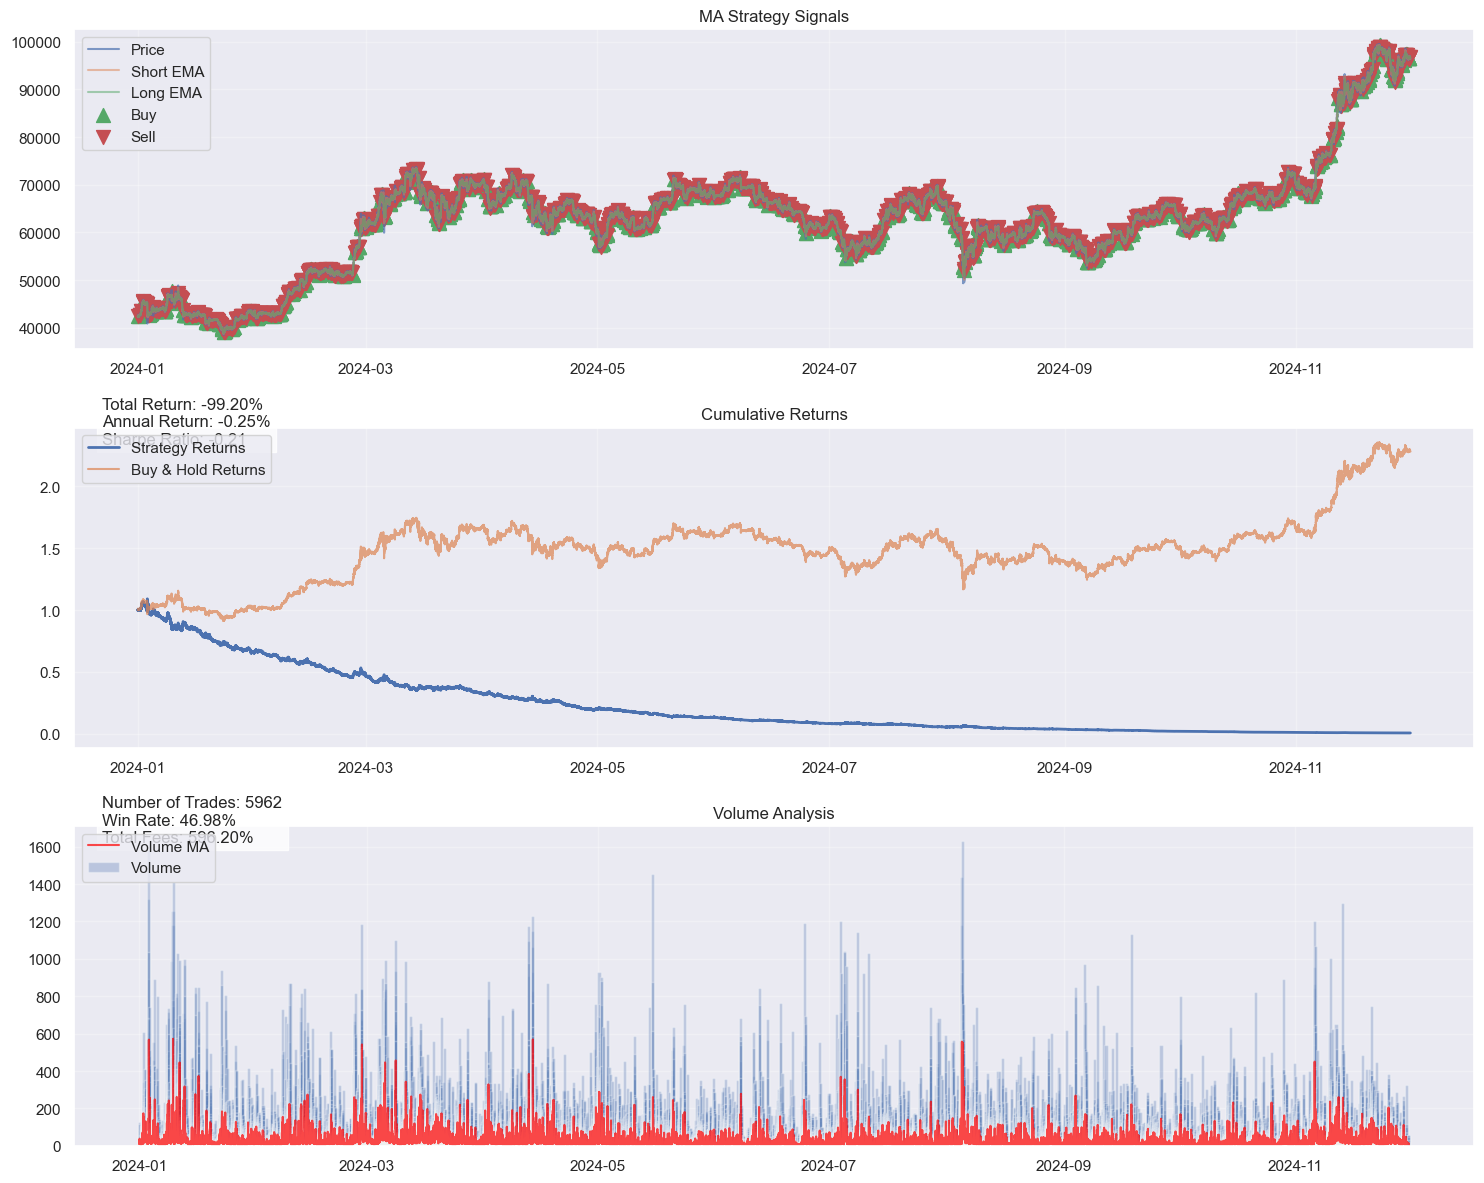

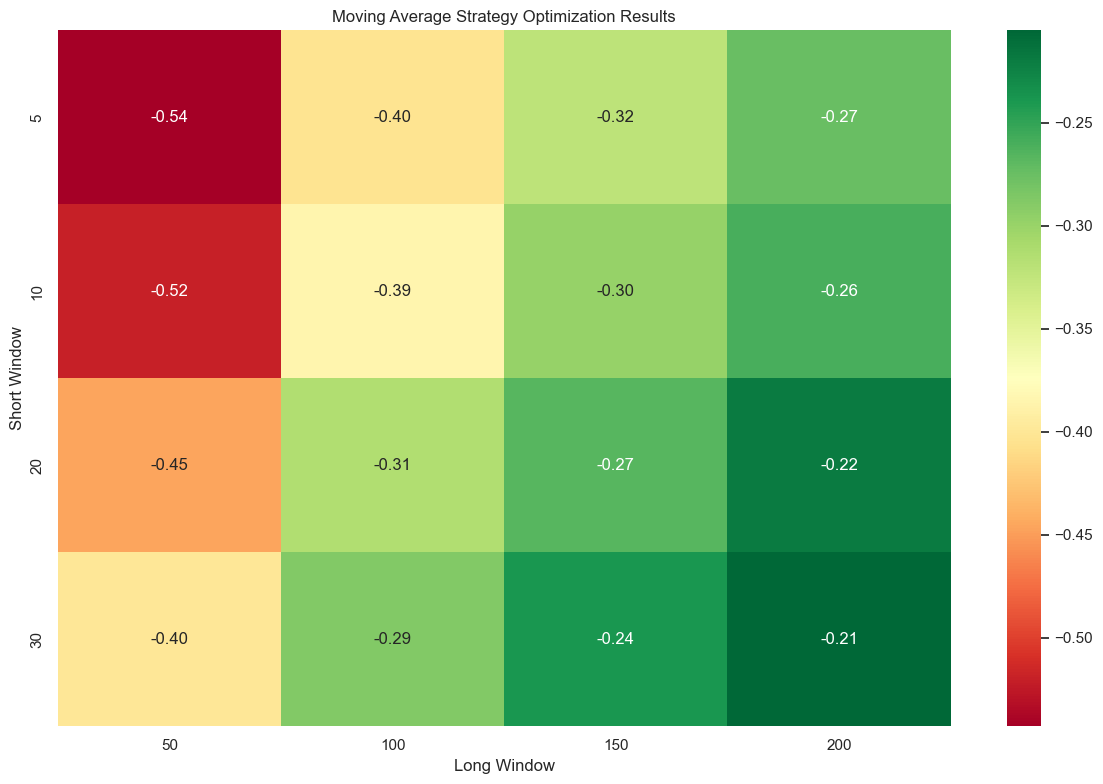


Bollinger Bands Strategy:
Strategy             Bollinger Bands
Total Return               -0.049457
Annualized Return          -0.000026
Sharpe Ratio                -0.05483
Max Drawdown               -0.049457
Volatility                  0.000481
Win Rate                    0.002332
Avg Win                     0.000276
Avg Loss                   -0.000295
Profit Factor               0.859987
Number of Trades                   9
Window                            10
Std Dev                          3.0
Name: 3, dtype: object


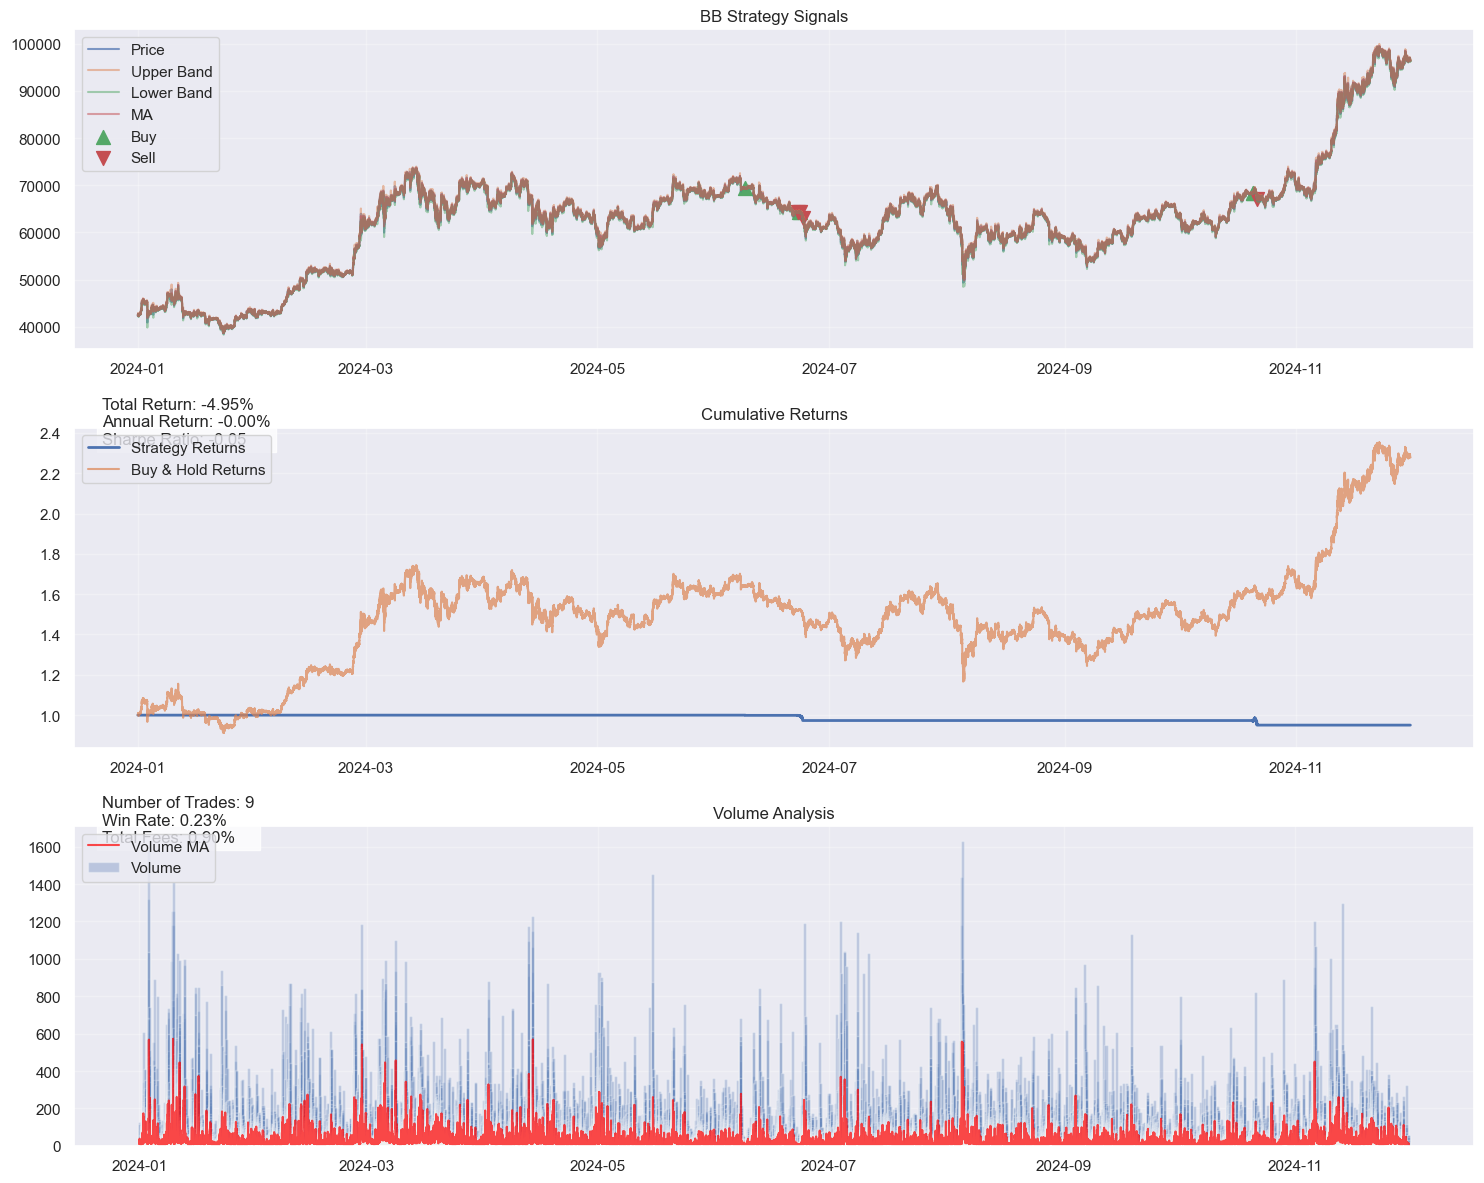

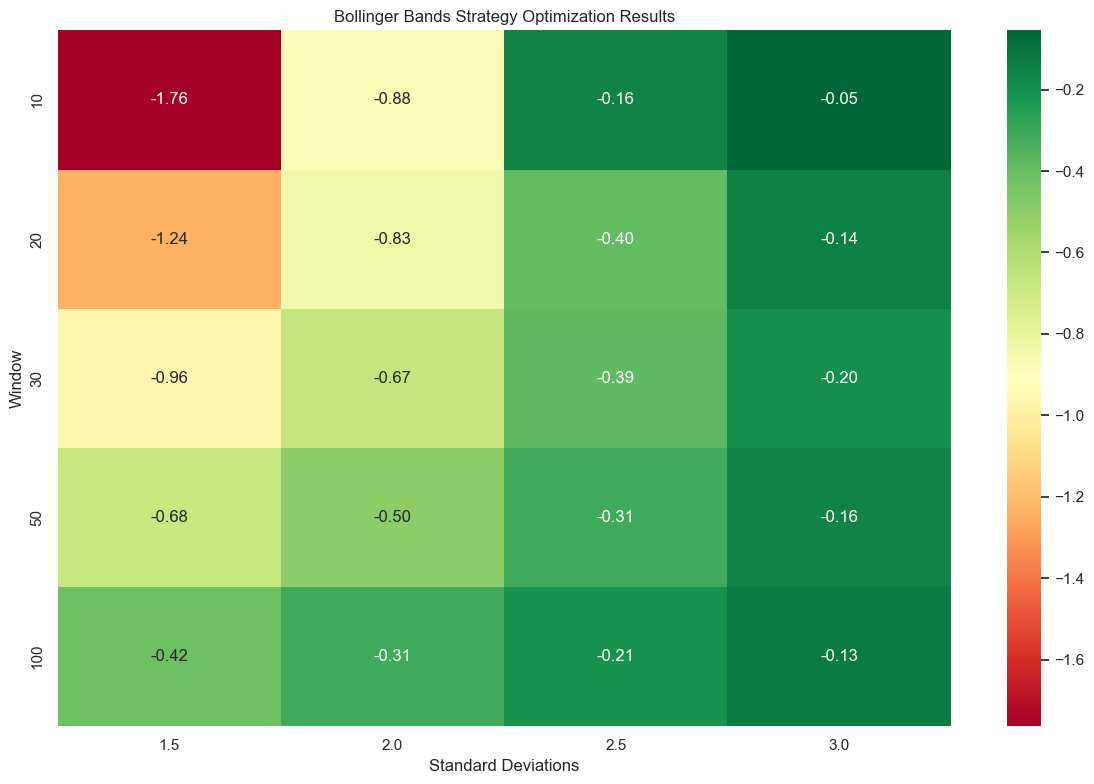


Best performing parameters for 5min:

Moving Average Strategy:
Strategy             MA Crossover
Total Return            -0.265517
Annualized Return       -0.000806
Sharpe Ratio            -0.017867
Max Drawdown            -0.388871
Volatility               0.026083
Win Rate                 0.473223
Avg Win                  0.001104
Avg Loss                -0.001074
Profit Factor            0.996473
Number of Trades             2371
Short Window                    5
Long Window                   200
Name: 3, dtype: object


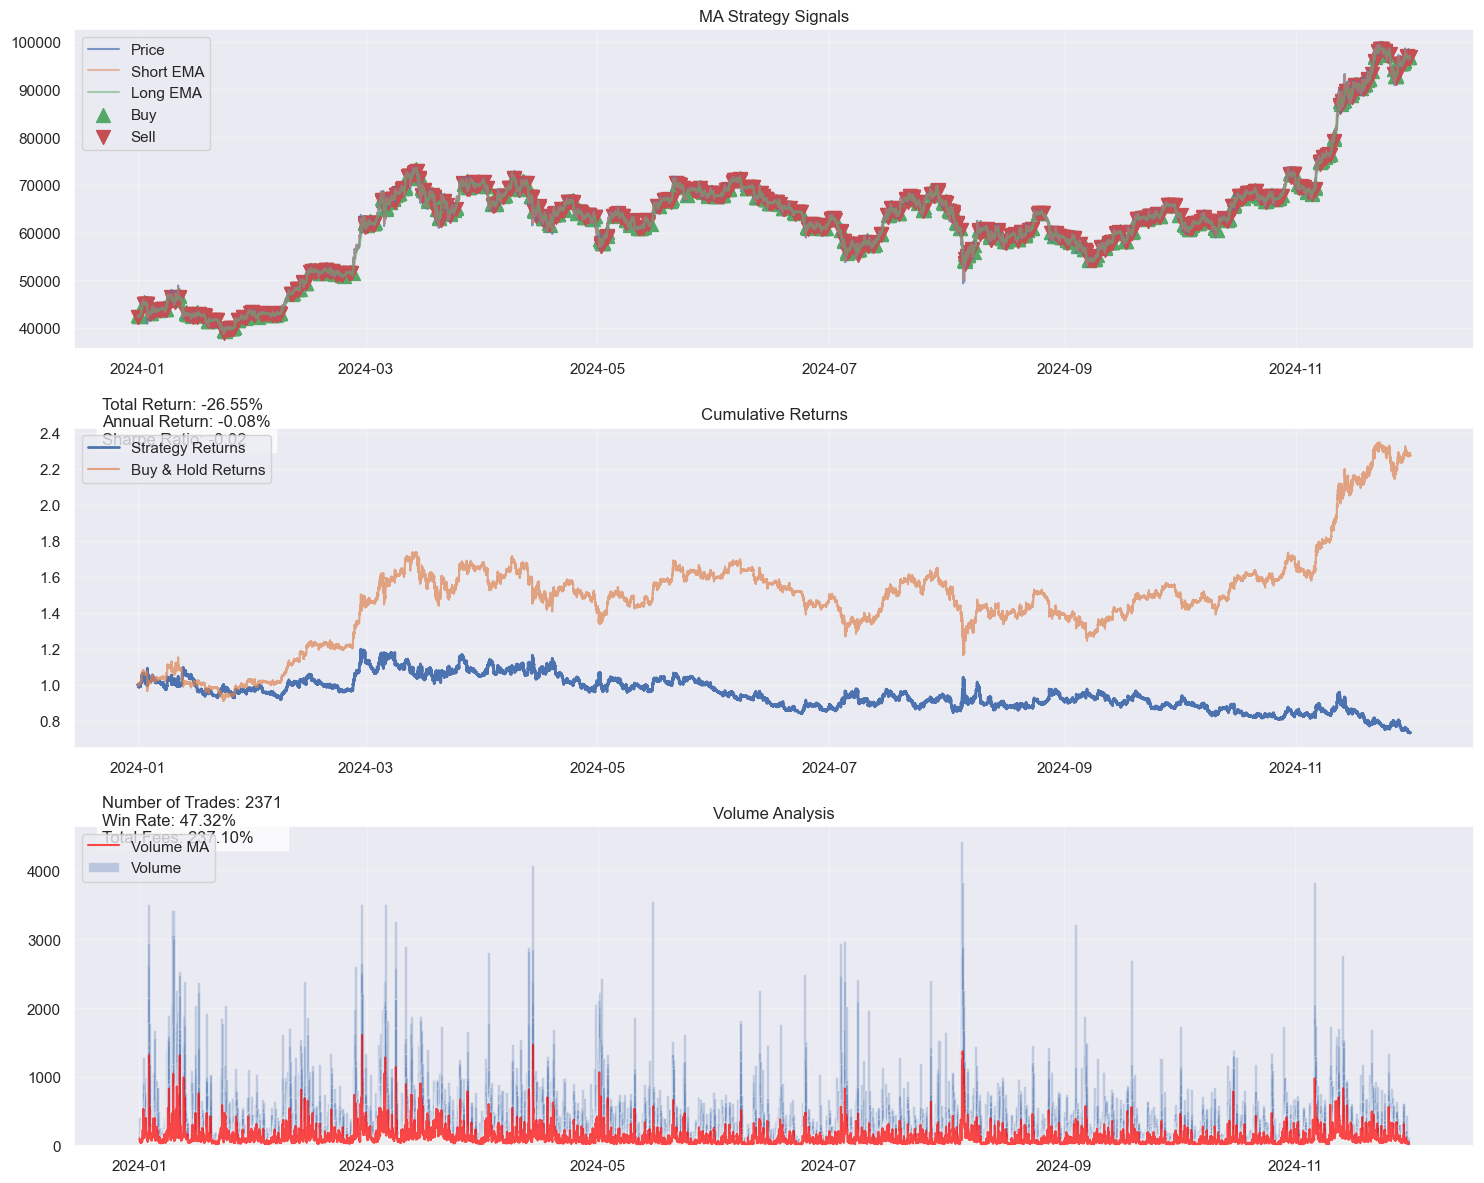

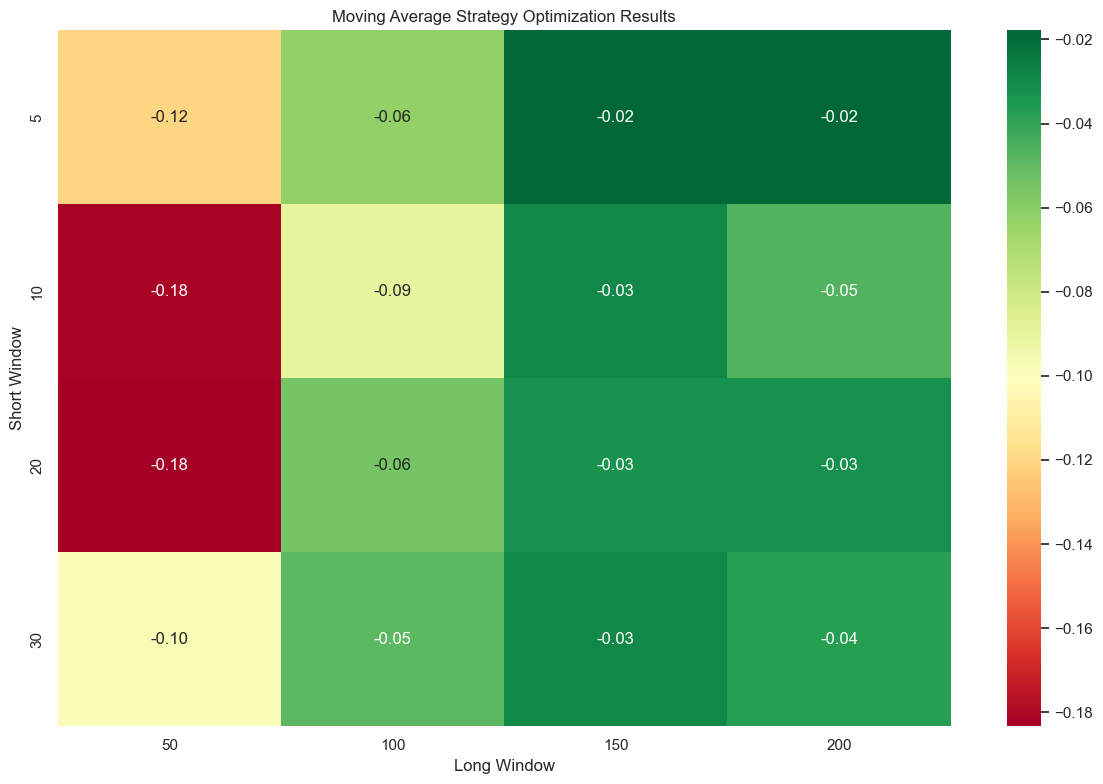


Bollinger Bands Strategy:
Strategy             Bollinger Bands
Total Return                     0.0
Annualized Return                0.0
Sharpe Ratio                     0.0
Max Drawdown                     0.0
Volatility                       0.0
Win Rate                         0.0
Avg Win                          0.0
Avg Loss                         0.0
Profit Factor                    0.0
Number of Trades                   0
Window                            10
Std Dev                          3.0
Name: 3, dtype: object


C:\Users\edoar\AppData\Local\Temp\ipykernel_2516\2706759334.py:54: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = np.sqrt(252) * df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()


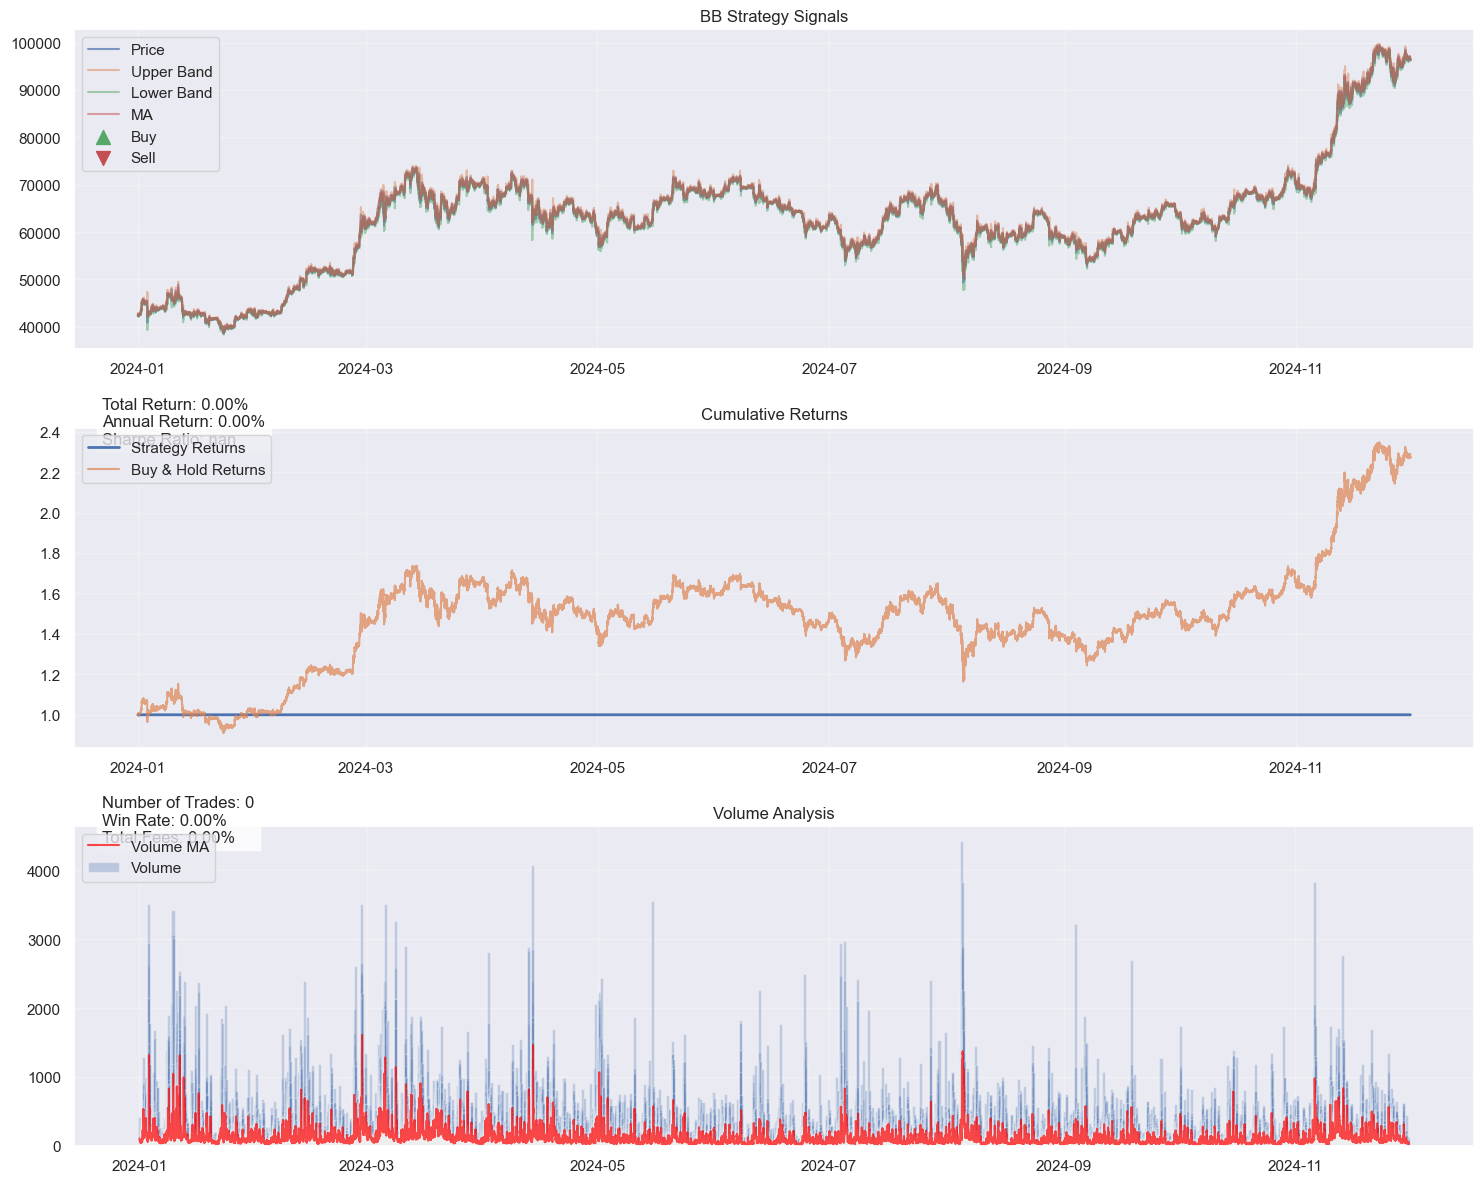

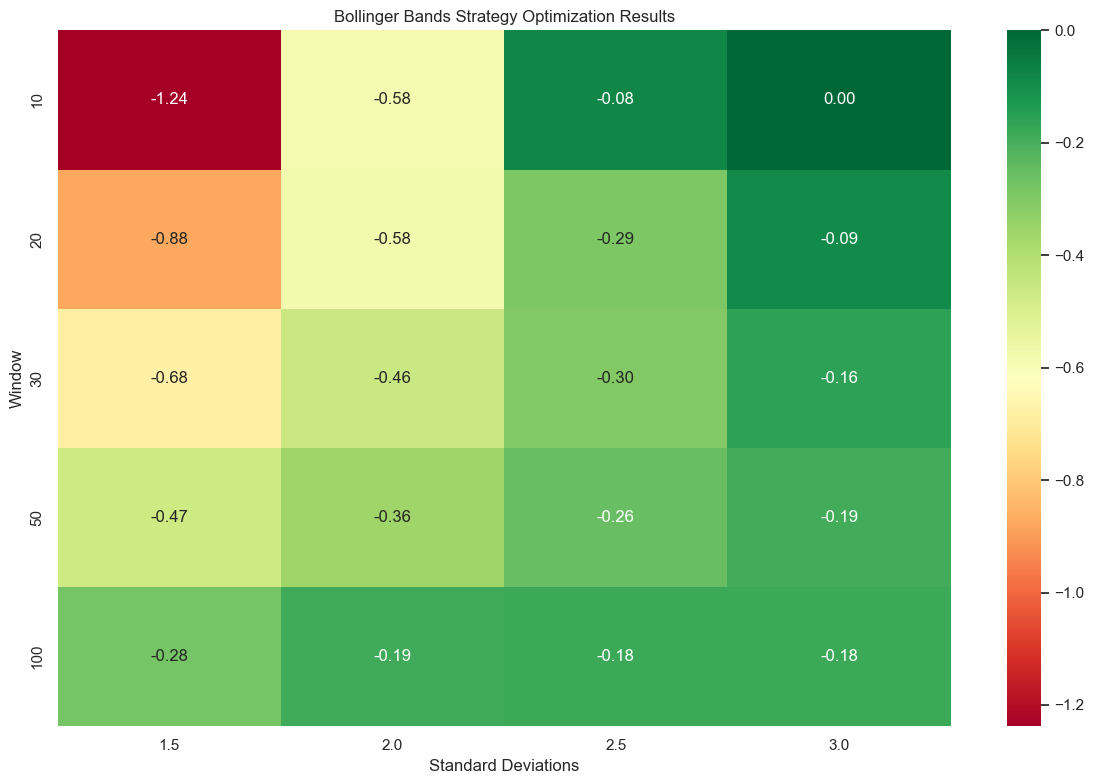


Best performing parameters for 15min:

Moving Average Strategy:
Strategy             MA Crossover
Total Return             2.256142
Annualized Return        0.009293
Sharpe Ratio             0.230521
Max Drawdown            -0.141104
Volatility               0.044401
Win Rate                  0.47797
Avg Win                  0.001939
Avg Loss                -0.001831
Profit Factor            1.045831
Number of Trades              944
Short Window                    5
Long Window                   150
Name: 2, dtype: object


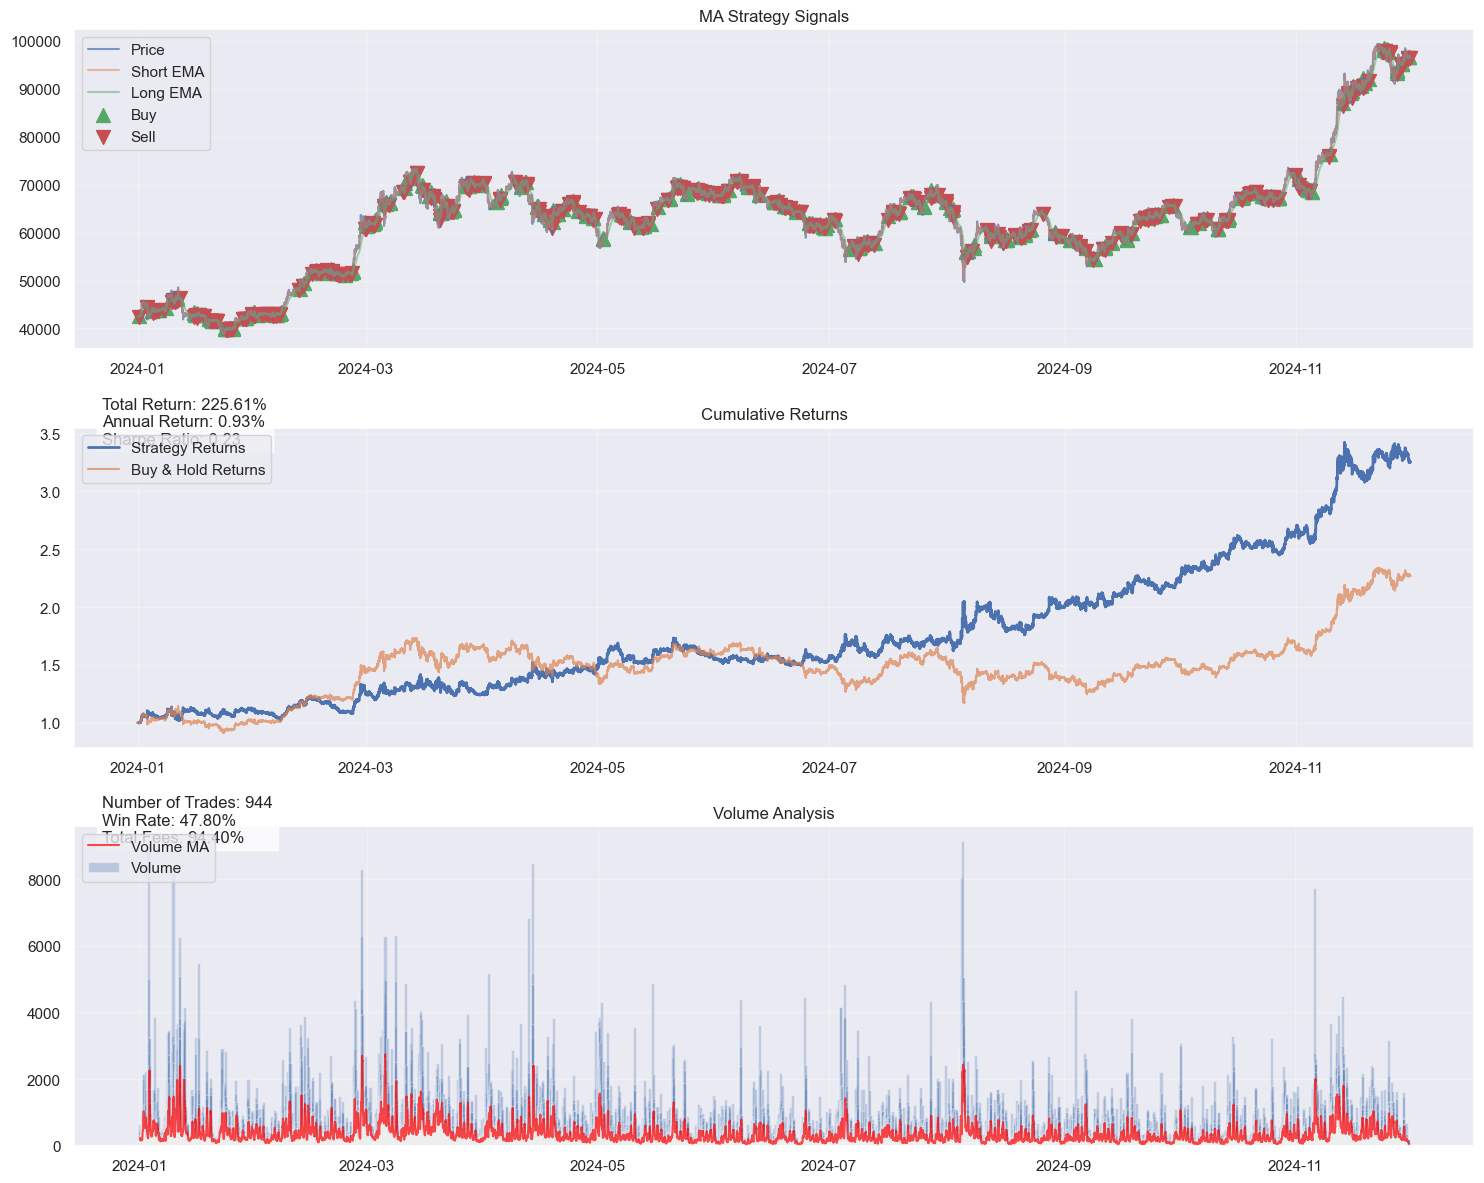

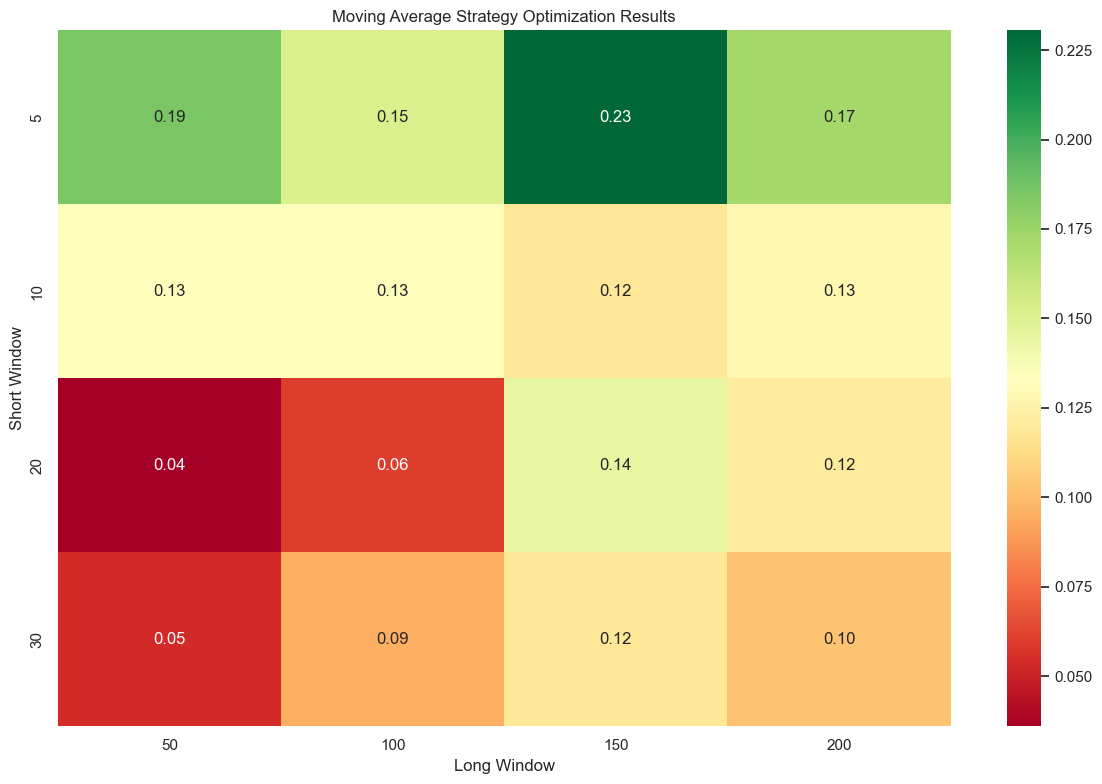


Bollinger Bands Strategy:
Strategy             Bollinger Bands
Total Return                0.161786
Annualized Return           0.001176
Sharpe Ratio                0.049749
Max Drawdown                -0.31809
Volatility                  0.038622
Win Rate                     0.35229
Avg Win                     0.001882
Avg Loss                   -0.001878
Profit Factor               1.011636
Number of Trades                 357
Window                           100
Std Dev                          3.0
Name: 19, dtype: object


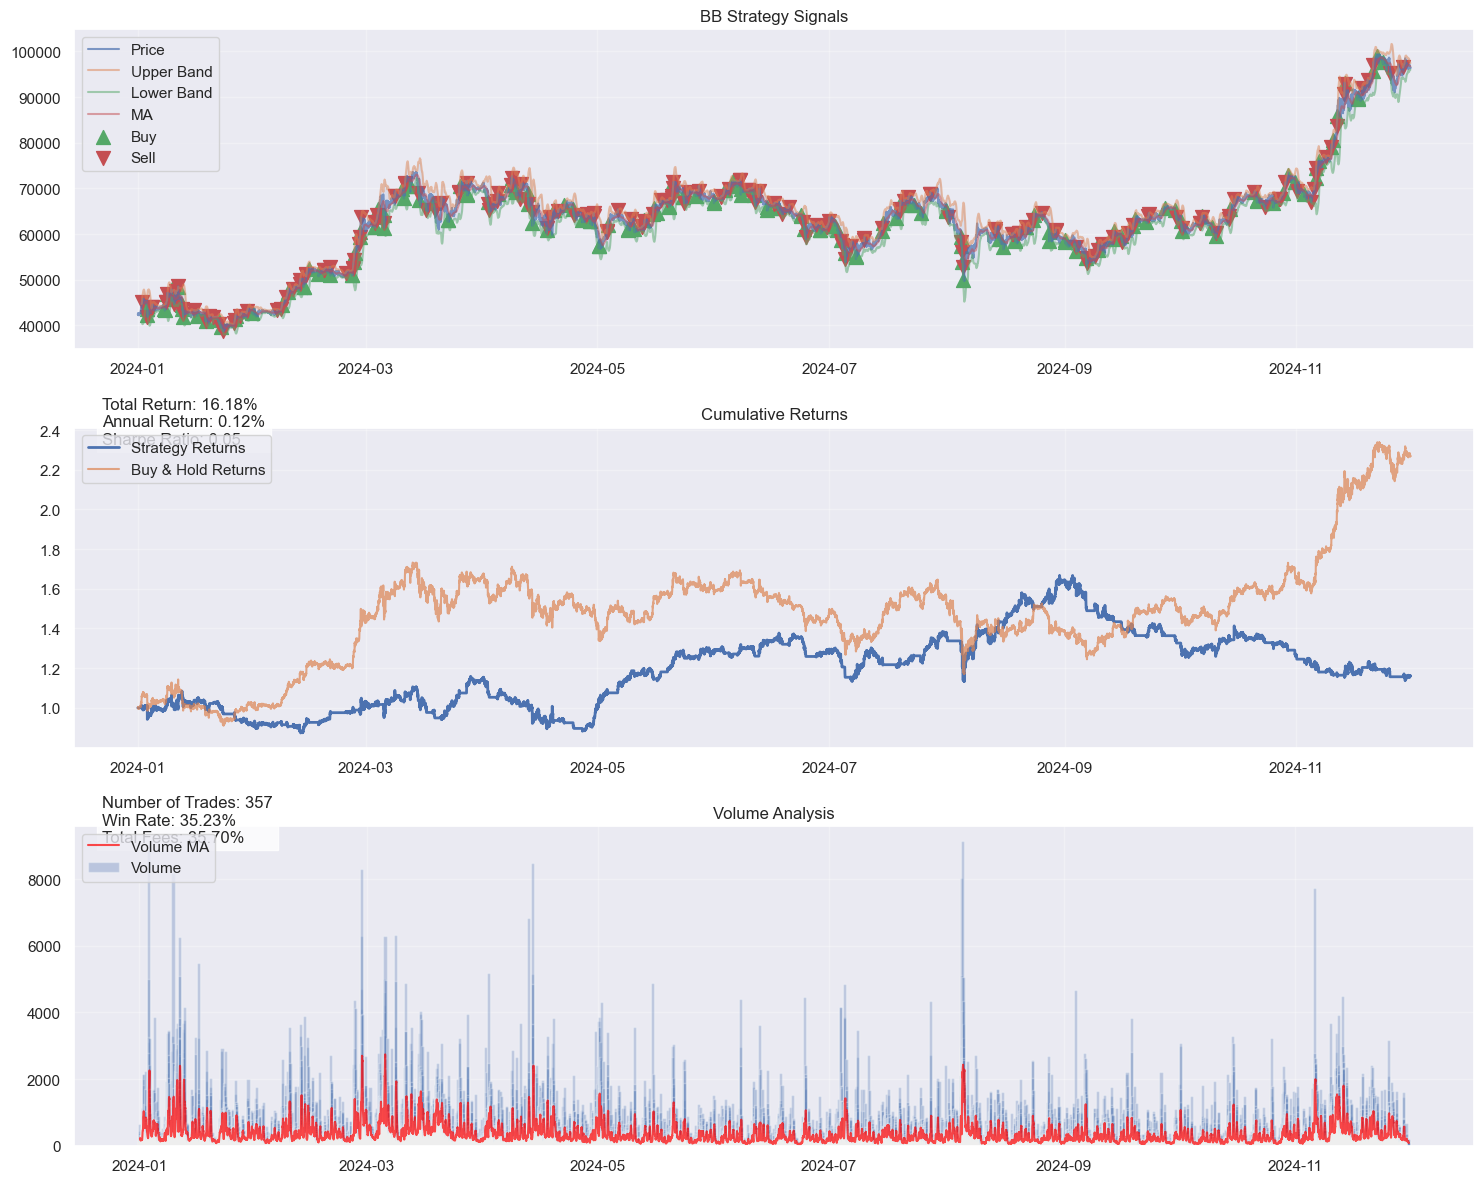

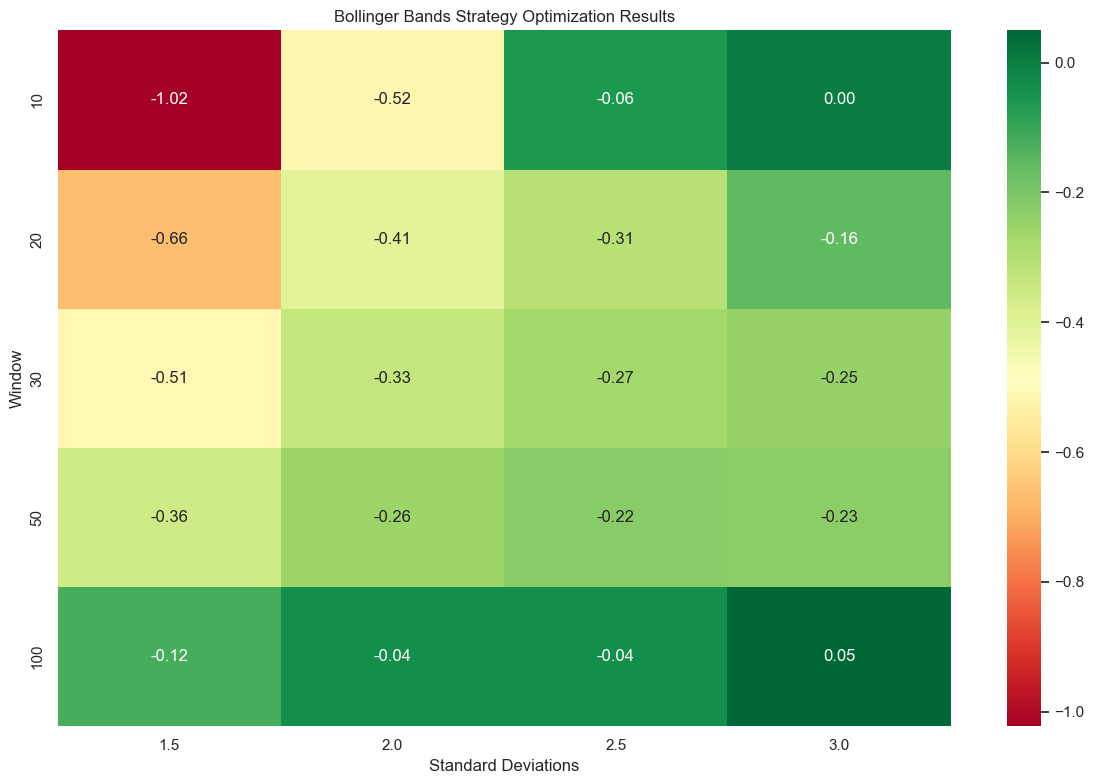

In [9]:
# Then visualize:
for timeframe, data in timeframes.items():
    print(f"\nBest performing parameters for {timeframe}:")
    
    # Moving Average Strategy
    ma_results = optimization_results[f'ma_{timeframe}']
    best_ma = ma_results.iloc[ma_results['Sharpe Ratio'].idxmax()]
    print("\nMoving Average Strategy:")
    print(best_ma)
    
    # First calculate MA indicators
    df_with_indicators = calculate_ma_indicators(
        data,
        short_window=int(best_ma['Short Window']),
        long_window=int(best_ma['Long Window'])
    )
    
    # Then generate signals using DataFrame with indicators
    df_ma = generate_ma_signals(
        df_with_indicators,  # Use DataFrame that already has indicators
        short_window=int(best_ma['Short Window']),
        long_window=int(best_ma['Long Window'])
    )
    plot_strategy_results(df_ma, 'MA')
    plot_optimization_results(ma_results, 'MA')
    
    # Bollinger Bands Strategy
    bb_results = optimization_results[f'bb_{timeframe}']
    best_bb = bb_results.iloc[bb_results['Sharpe Ratio'].idxmax()]
    print("\nBollinger Bands Strategy:")
    print(best_bb)
    
    # First calculate BB indicators
    df_with_bb = calculate_bb_indicators(
        data,
        window=int(best_bb['Window']),
        std_dev=best_bb['Std Dev']
    )
    
    # Then generate signals using DataFrame with indicators
    df_bb = generate_bb_signals(
        df_with_bb,  # Use DataFrame that already has indicators
        window=int(best_bb['Window']),
        std_dev=best_bb['Std Dev']
    )
    plot_strategy_results(df_bb, 'BB')
    plot_optimization_results(bb_results, 'BB')

In [10]:
# Create summary statistics from optimization results
print("\nStrategy Performance Summary:")
summary_stats = pd.DataFrame()

for key, results in optimization_results.items():
    if not results.empty:
        best_result = results.iloc[results['Sharpe Ratio'].idxmax()]
        
        # Clean up the columns to display
        summary_data = {
            'Strategy': 'Moving Average' if 'ma_' in key else 'Bollinger Bands',
            'Timeframe': key.split('_')[1],
            'Sharpe Ratio': best_result['Sharpe Ratio'],
            'Total Return': best_result['Total Return'],
            'Max Drawdown': best_result['Max Drawdown'],
            'Win Rate': best_result['Win Rate'],
            'Number of Trades': best_result['Number of Trades'],
            'Parameters': (f"Short={int(best_result['Short Window'])}, Long={int(best_result['Long Window'])}" 
                         if 'ma_' in key else 
                         f"Window={int(best_result['Window'])}, Std={best_result['Std Dev']}")
        }
        summary_stats[key] = pd.Series(summary_data)

# Format and display summary
formatted_summary = summary_stats.T
formatted_summary['Total Return'] = formatted_summary['Total Return'].map('{:.2%}'.format)
formatted_summary['Max Drawdown'] = formatted_summary['Max Drawdown'].map('{:.2%}'.format)
formatted_summary['Win Rate'] = formatted_summary['Win Rate'].map('{:.2%}'.format)
formatted_summary['Sharpe Ratio'] = formatted_summary['Sharpe Ratio'].map('{:.2f}'.format)

print("\nSummary Statistics:")
print(formatted_summary)

# Find best overall strategy
best_strategy = formatted_summary.loc[formatted_summary['Sharpe Ratio'].astype(float).idxmax()]
print("\nBest Overall Strategy:")
print(f"Strategy: {best_strategy['Strategy']}")
print(f"Timeframe: {best_strategy['Timeframe']}")
print(f"Parameters: {best_strategy['Parameters']}")
print(f"Sharpe Ratio: {best_strategy['Sharpe Ratio']}")
print(f"Total Return: {best_strategy['Total Return']}")
print(f"Max Drawdown: {best_strategy['Max Drawdown']}")
print(f"Win Rate: {best_strategy['Win Rate']}")
print(f"Number of Trades: {best_strategy['Number of Trades']}")

# Save results with proper formatting
formatted_summary.to_csv('strategy_summary.csv')


Strategy Performance Summary:

Summary Statistics:
                 Strategy Timeframe Sharpe Ratio Total Return Max Drawdown  \
ma_1min    Moving Average      1min        -0.21      -99.20%      -99.27%   
bb_1min   Bollinger Bands      1min        -0.05       -4.95%       -4.95%   
ma_5min    Moving Average      5min        -0.02      -26.55%      -38.89%   
bb_5min   Bollinger Bands      5min         0.00        0.00%        0.00%   
ma_15min   Moving Average     15min         0.23      225.61%      -14.11%   
bb_15min  Bollinger Bands     15min         0.05       16.18%      -31.81%   

         Win Rate Number of Trades           Parameters  
ma_1min    46.98%             5962   Short=30, Long=200  
bb_1min     0.23%                9   Window=10, Std=3.0  
ma_5min    47.32%             2371    Short=5, Long=200  
bb_5min     0.00%                0   Window=10, Std=3.0  
ma_15min   47.80%              944    Short=5, Long=150  
bb_15min   35.23%              357  Window=100, Std=3

## Analysis of Strategy Performance Across Timeframes

The results reveal striking performance variations between the Moving Average and Bollinger Bands strategies across different timeframes, with particularly notable results in the higher time intervals. The Moving Average strategy demonstrated extreme sensitivity to timeframe selection, showing a clear progression from catastrophic performance at the one-minute level to exceptional returns at fifteen minutes.

In the one-minute timeframe, the Moving Average strategy suffered devastating losses, returning -99.20%. This poor performance likely stems from the strategy being overwhelmed by market microstructure noise, where rapid price fluctuations generate false signals and transaction costs erode any potential gains. The five-minute timeframe showed improvement but still remained firmly in negative territory with a -26.55% return, suggesting that these shorter intervals still fail to capture meaningful price movements effectively.

However, the strategy underwent a remarkable transformation at the fifteen-minute timeframe, generating an impressive 225.61% return. This dramatic improvement suggests that fifteen-minute intervals better capture genuine market trends while filtering out the noise that plagued shorter timeframes. Interestingly, the strategy maintained a consistently robust win rate between 46-48% across all timeframes, indicating that the signal generation mechanism remains fundamentally sound. The substantial performance difference therefore appears to stem from the varying magnitude of wins versus losses rather than the accuracy of trade signals.

The Bollinger Bands strategy presents a notably different picture, characterized by minimal trading activity across shorter timeframes. The strategy generated just nine trades in the one-minute timeframe and, surprisingly, completely ceased activity in the five-minute timeframe. This inactivity likely results from overly conservative parameter settings, particularly the 3.0 standard deviation threshold, which may have placed the bands too far from the mean price to generate meaningful signals. The fifteen-minute timeframe showed more reasonable activity with 357 trades, though still significantly fewer than the Moving Average strategy's 944 trades at the same interval.

When comparing the two strategies, the substantial difference in trading frequency at the fifteen-minute timeframe (944 versus 357 trades) highlights their fundamentally different approaches to market behavior. The Moving Average strategy actively engages with trending movements, while the Bollinger Bands strategy waits for extreme statistical deviations before entering positions. This difference in approach proved particularly significant during periods of strong trending behavior, which naturally favored the Moving Average strategy's methodology.

The underperformance of the Bollinger Bands strategy, especially given the strong showing of the Moving Average approach, suggests potential areas for optimization. The conservative parameter settings, while intended to reduce false signals, may have overcorrected and prevented the strategy from capturing profitable opportunities. Additionally, the volume filtering mechanism may have disproportionately affected Bollinger Bands signals, further reducing trading opportunities.

This comprehensive analysis reveals that both strategies perform optimally at higher timeframes, though with varying degrees of success. The Moving Average strategy demonstrates particular strength in capturing intraday trends, performing best during periods of clear directional movement and effectively limiting losses during sideways price action. Meanwhile, the Bollinger Bands strategy's performance suggests room for parameter optimization, particularly in relaxing the standard deviation thresholds to generate more trading opportunities while maintaining risk management principles.

An additional element to consider is that the backtest assumed that the execution price of the market order would be the same as the last closing price. This is unlikely to be the case but it is a close enough approximation to the implementation of the live trading code where a market order is instructed.